# Train detector

## Mount Google Drive
To begin, let's mount our google drive using the `mount` function from `google.colab.drive`.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [ ]:
%%bash
cd /content/gdrive/MyDrive/CVCS/project_folder
pip install https://github.com/phil-bergmann/tracking_wo_bnw/archive/master.zip
pip install coloredlogs
pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

# Print bbox from MOTSynth annotation
image 57, frame 0000


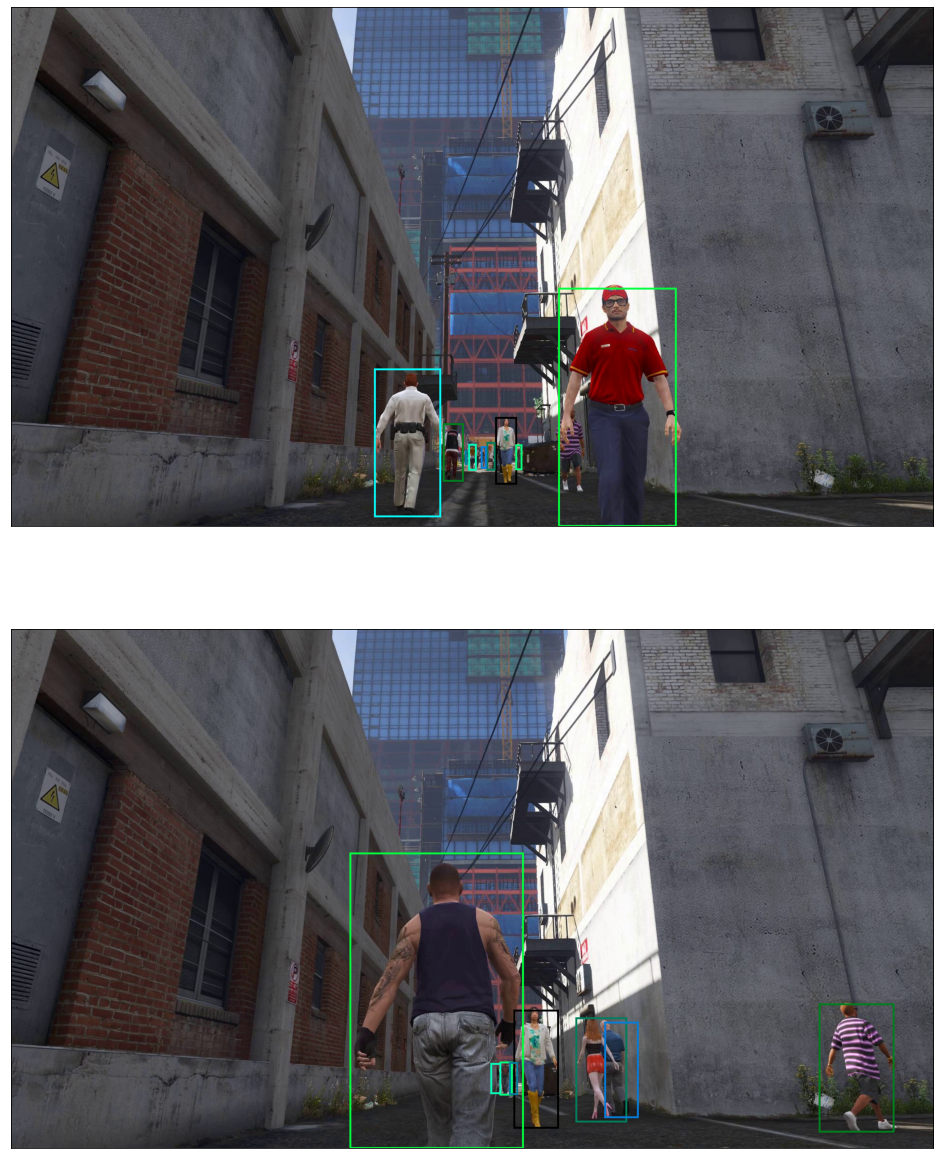

In [ ]:
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from matplotlib.pyplot import figure
plt.rcParams["savefig.bbox"] = 'tight'
import pandas as pd

img57_frame0 = read_image("/content/gdrive/MyDrive/CVCS/storage/MOTSynth/frames/057/rgb/0000.jpg")
img57_frame100 = read_image("/content/gdrive/MyDrive/CVCS/storage/MOTSynth/frames/057/rgb/0100.jpg")
ann_path = "/content/gdrive/MyDrive/CVCS/storage/MOTSynth/mot_annotations/057/gt/gt.txt"


def read_MOT_annotations(path):
  annotations = open(path,"r") 
  my_text = annotations.read().splitlines()
  outputs = []  
  for ann in my_text:
      output = {}
      #parse annotations
      el = ann.split(',')
      frame = el[0]
      id = int(el[1])
      boxes = el[2:2+4]
      boxes = list(int(item) for item in boxes)
      boxes[2] = boxes[0]+boxes[2]
      boxes[3] = boxes[1]+boxes[3]
      boxes = tuple(boxes)
      scores = float(el[-4])
      output["frame"] = frame
      output["id"] = id
      output["boxes"] = boxes
      output["scores"] = scores
      outputs.append(output)
  return outputs

anns = read_MOT_annotations(ann_path)

anns_df = pd.DataFrame(anns, columns=['frame', 'id', 'boxes', 'scores'])
frame0_anns = anns_df[anns_df["frame"]=='1']
frame100_anns = anns_df[anns_df["frame"]=='101']

images_list = [img57_frame0, img57_frame100]
anns_outputs = [{
    "boxes": torch.tensor(frame0_anns["boxes"].to_list()),
    "scores": torch.tensor(frame0_anns["scores"].to_list())
    },
    {
    "boxes": torch.tensor(frame100_anns["boxes"].to_list()),
    "scores": torch.tensor(frame100_anns["scores"].to_list())
    }]

score_threshold = 0.6

images_with_boxes = [
    draw_bounding_boxes(img_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for img_int, output in zip(images_list, anns_outputs)
]


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(nrows=len(imgs), ncols=1, figsize=(45,21), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        img = np.asarray(img)
        axs[i,0].imshow(img)
        axs[i,0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(images_with_boxes)


# print bbox from pretrained faster Rcnn weights

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


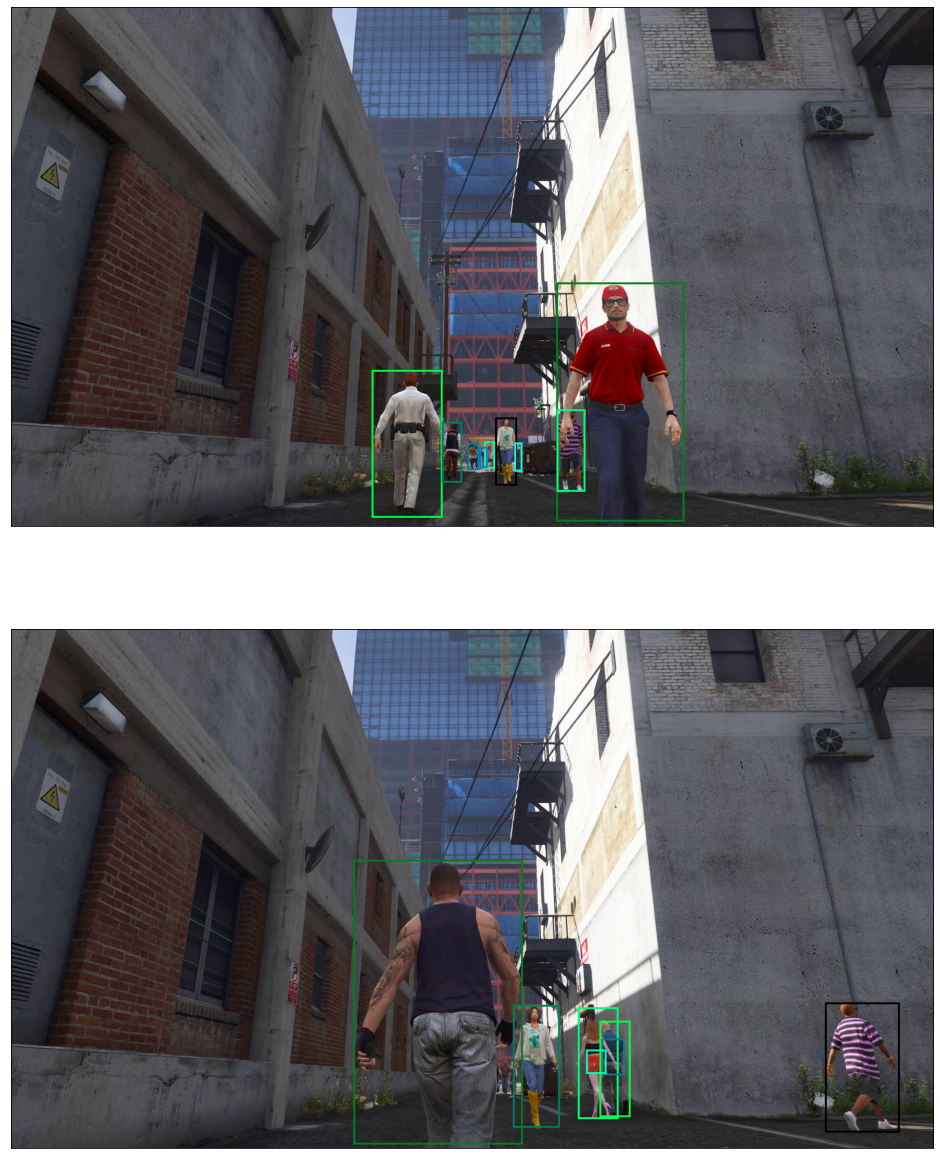

In [ ]:
import torch
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from matplotlib.pyplot import figure
plt.rcParams["savefig.bbox"] = 'tight'

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
transforms = weights.transforms()

img57_frame0 = read_image("/content/gdrive/MyDrive/CVCS/storage/MOTSynth/frames/057/rgb/0000.jpg")
img57_frame100 = read_image("/content/gdrive/MyDrive/CVCS/storage/MOTSynth/frames/057/rgb/0100.jpg")
imgs_list = [img57_frame0, img57_frame100]
imgs_transformed = [transforms(d) for d in imgs_list]

model = fasterrcnn_resnet50_fpn_v2(weights=weights, progress=False)
model = model.eval()

model.to("cuda")
imgs_tensor = [d.to("cuda") for d in imgs_transformed]

fasterRCNN_outputs = model(imgs_tensor)

imgs_tensor = [torch.clip(d*255,0,255) for d in imgs_tensor]
imgs_tensor = [d.type(torch.uint8) for d in imgs_tensor]

score_threshold = .75

images_with_boxes = [
    draw_bounding_boxes(img_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for img_int, output in zip(imgs_tensor, fasterRCNN_outputs)
]

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(nrows=len(imgs), ncols=1, figsize=(45,21), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        img = np.asarray(img)
        axs[i,0].imshow(img)
        axs[i,0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(images_with_boxes)


# Faster rcnn fine-tuning on MOTSynth

In [ ]:
# %%bash
# chmod 755 /content/gdrive/MyDrive/CVCS/project_folder/cvcs/scripts/train_detector.sh
# cd /content/gdrive/MyDrive/CVCS/project_folder/cvcs
# scripts/train_detector.sh > TrainLog.txt

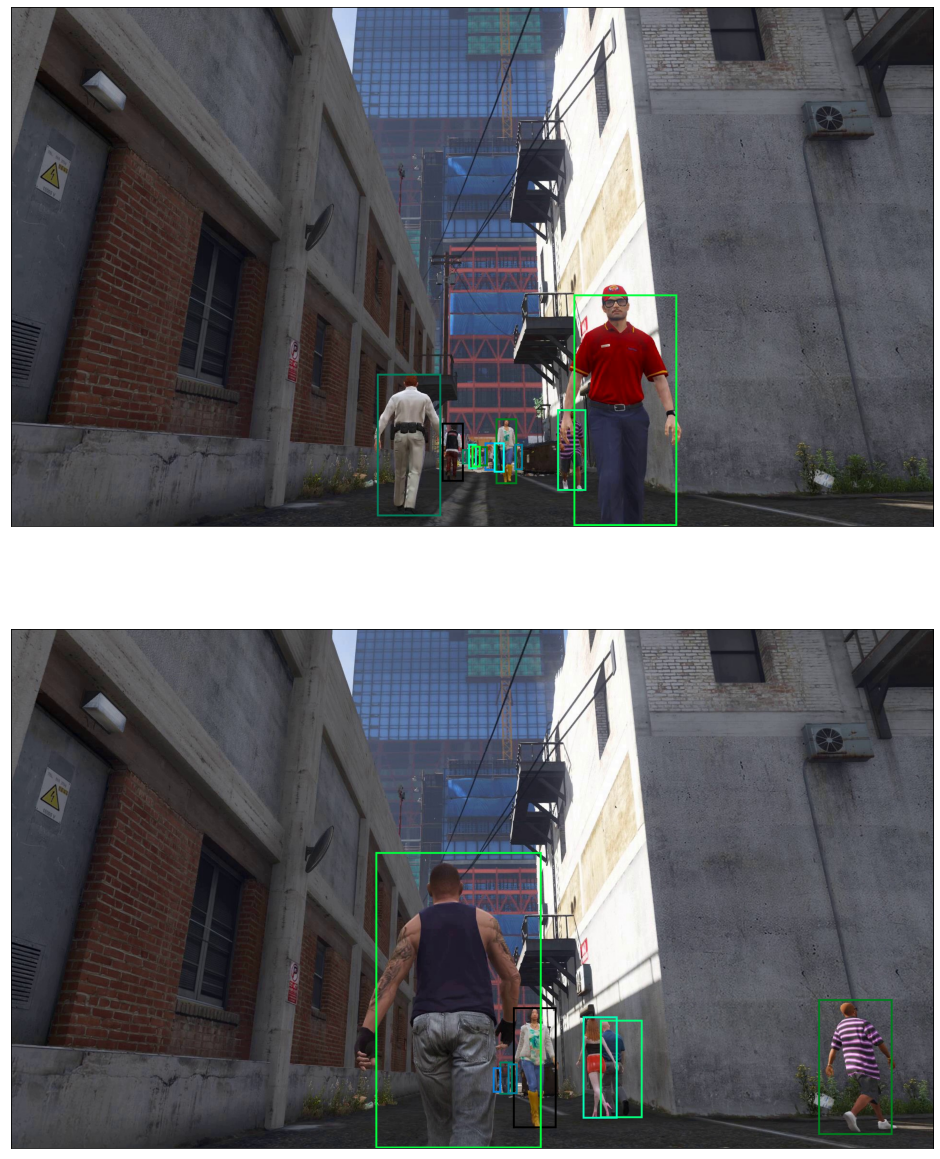

In [ ]:
import torch
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from matplotlib.pyplot import figure
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

plt.rcParams["savefig.bbox"] = 'tight'

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
transforms = weights.transforms()

img57_frame0 = read_image("/content/gdrive/MyDrive/CVCS/storage/MOTSynth/frames/057/rgb/0000.jpg")
img57_frame100 = read_image("/content/gdrive/MyDrive/CVCS/storage/MOTSynth/frames/057/rgb/0100.jpg")
imgs_list = [img57_frame0, img57_frame100]
imgs_transformed = [transforms(d) for d in imgs_list]

model = fasterrcnn_resnet50_fpn_v2()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2) 
checkpoint = torch.load("/content/gdrive/MyDrive/CVCS/storage/motsynth_output/detection_logs/fasterrcnn_training/checkpoint.pth", map_location="cpu")
model.load_state_dict(checkpoint["model"])
model = model.eval()

model.to("cuda")
imgs_tensor = [d.to("cuda") for d in imgs_transformed]

fasterRCNN_outputs = model(imgs_tensor)

imgs_tensor = [torch.clip(d*255,0,255) for d in imgs_tensor]
imgs_tensor = [d.type(torch.uint8) for d in imgs_tensor]

score_threshold = .8

images_with_boxes = [
    draw_bounding_boxes(img_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for img_int, output in zip(imgs_tensor, fasterRCNN_outputs)
]

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(nrows=len(imgs), ncols=1, figsize=(45,21), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        img = np.asarray(img)
        axs[i,0].imshow(img)
        axs[i,0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(images_with_boxes)


In [ ]:
anns = anns_outputs[0]['boxes']
image_pred = fasterRCNN_outputs[0]['boxes'][fasterRCNN_outputs[0]['scores'] > 0.75].cpu().detach().numpy()
image_pred = np.round(image_pred)

print(anns)
print(image_pred)

print(f'anns_lenght: {len(anns)}')
print(f"image_pred_lenght: {len(image_pred)}")



tensor([[1007,  853, 1052,  993],
        [1002,  912, 1018,  964],
        [ 975,  921,  987,  951],
        [1006,  908, 1023,  964],
        [ 954,  916,  970,  961],
        [1130,  837, 1189, 1008],
        [ 898,  866,  941,  987],
        [1003,  903, 1026,  968],
        [1138,  584, 1384, 1081],
        [ 961,  917,  976,  960],
        [ 990,  916, 1007,  959],
        [ 994,  917, 1011,  958],
        [ 989,  905, 1007,  964],
        [1028,  909, 1048,  962],
        [1049,  910, 1063,  963],
        [1010,  897, 1037,  971],
        [ 944,  922,  949,  952],
        [ 951,  909,  968,  964],
        [ 977,  914,  989,  960],
        [ 755,  752,  894, 1061]])
[[ 897.  865.  941.  987.]
 [1009.  857. 1052.  992.]
 [1170.  598. 1386. 1079.]
 [ 761.  764.  894. 1060.]
 [1136.  838. 1197. 1006.]
 [1048.  909. 1065.  964.]
 [ 951.  909.  968.  962.]
 [ 986.  907. 1007.  964.]
 [1005.  906. 1027.  969.]
 [ 975.  915.  991.  956.]
 [ 959.  914.  977.  957.]
 [ 938.  921.  951.  9